# Water detection and dam monitoring from Sentinel 2 imagery <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook, like the [Water_extent.ipynb](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Water_extent.ipynb), primarily focuses on the first sub-indicator - spatial extents. It does not however use the  [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product but Sentinel 2 only.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import sys
import datacube
import geopandas as gpd
from shapely.geometry import Polygon

sys.path.append('../Scripts')
from deafrica_datahandling import mostcommon_crs
from deafrica_datahandling import load_ard, wofs_fuser
from deafrica_spatialtools import xr_vectorize, xr_rasterize
from deafrica_plotting import display_map, rgb
from deafrica_bandindices import calculate_indices
from deafrica_classificationtools import HiddenPrints
from deafrica_dask import create_local_dask_cluster

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
dc = datacube.Datacube(app="water_Theewaterskloof")

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42253 Dashboard: /user/arkriger/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [4]:
path = '../Supplementary_data/WorkingFolder/Theewaterskloof.shp'
field = 'NAME'

#read shapefile and ensure its in WGS84 coordinates
dam_nominal = gpd.read_file(path).to_crs('epsg:4326')
#reproject it to a local utm
#dam_nominal = gpd.read_file(path).to_crs('epsg:32734')


In [5]:
# inflate the BBOX
inflate_bbox = 0.1
minx, miny, maxx, maxy = dam_nominal.at[0, 'geometry'].bounds

delx = maxx - minx
dely = maxy - miny
minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox


polygon = ((minx, miny),(minx, maxy),(maxx, maxy),(maxx, miny))

dam_bbox = Polygon(polygon)
dam_bbox = gpd.GeoDataFrame(index=[0], geometry=[dam_bbox])  
dam_bbox = dam_bbox.set_crs(dam_nominal.crs)


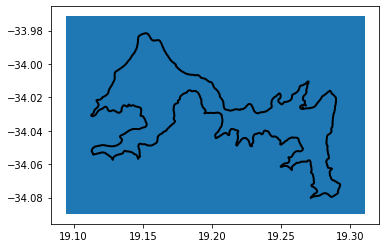

In [6]:
fig, ax = plt.subplots()
dam_bbox.plot(ax=ax)
dam_nominal.plot(color=None, edgecolor='k', linewidth = 2, ax=ax)
plt.show()

In [7]:
# Define the area of interest
lat =  dam_bbox.centroid.y
lon =  dam_bbox.centroid.x

#lat = -34.02
#lon = 19.20

#change shape - square, rectangle
lat_buffer = 0.104
lon_buffer = 0.104

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
display_map(x=lon_range, y=lat_range)

In [9]:
# Define the start year and end year
start_year = '2017-01-01'
end_year = '2020-08-01'

#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-10, 10),
    'output_crs':'EPSG:6933',
    'group_by': 'solar_day',
    'time': (start_year, end_year),
    'dask_chunks':{'time':1,'x':1000,'y':1000}
}

In [10]:
ds_sen2 = load_ard(dc=dc,
                      products=['s2_l2a'],
                      measurements=['red', 'green', 'blue', 'nir'],
                      min_gooddata = 0.75,
                      **query)

../Scripts/deafrica_datahandling.py:240: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 121 out of 236 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Returning 121 time steps as a dask array


In [11]:
# Calculate NDWI and add it to the loaded data set
ds_sen2 = calculate_indices(ds_sen2, index="NDWI", collection="s2")
ds_index = ds_sen2.NDWI

In [24]:
# Dictionary to save results 
results = {}

# A progress indicator
i = 0

# Loop through polygons in geodataframe
for index, row in dam_nominal.iterrows():
    
    # Generate a polygon mask to keep only data within the polygon
    with HiddenPrints():
        mask = xr_rasterize(dam_nominal.iloc[[index]], ds_sen2)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds_index = ds_index.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[field]) : ds_sen2})
    
    # Update counter
    i += 1

In [28]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

area_per_pixel = pixel_length**2 / m_per_km**2

In [29]:
# Filter the data to contain only pixels classified as water
ds_waterarea = ds_sen2.where(ds_sen2.NDWI > 0.1)

# Calculate the total water area (in km^2)
waterarea = (
    ds_waterarea.NDWI.count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

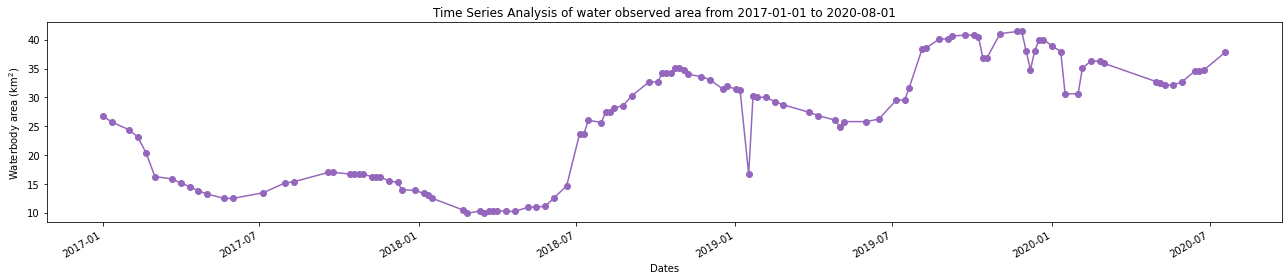

In [30]:
plt.figure(figsize=(18, 4))
waterarea.plot(marker='o', color='#9467bd')
plt.title(f'Time Series Analysis of water observed area from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

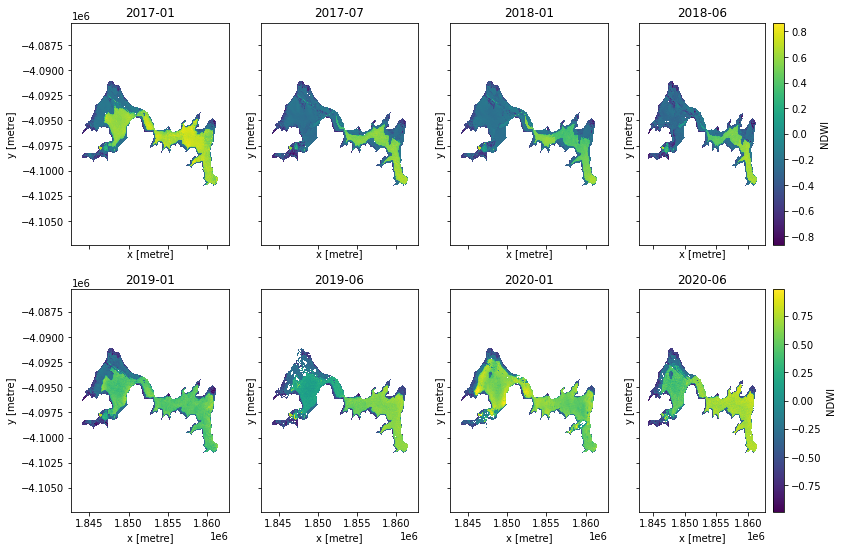

In [27]:
timestep_1 = 0
timestep_2 = 12
timestep_3 = 30
timestep_4 = 41
timestep_5 = 70
timestep_6 = 83
timestep_7 = 104
timestep_8 = 119


# Plot water extent
fig, ax = plt.subplots(2, 4, figsize=(13, 9), sharex=True, sharey=True)

# plot the water extent from WOfS
#ds_wofs.isel(time=timestep_1).water.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

ds_index.isel(time=timestep_1).plot.imshow(ax=ax[0,0],cmap="viridis", add_colorbar=False)
ds_index.isel(time=timestep_2).plot.imshow(ax=ax[0,1],cmap="viridis", add_colorbar=False)
ds_index.isel(time=timestep_3).plot.imshow(ax=ax[0,2],cmap="viridis", add_colorbar=False)
ds_index.isel(time=timestep_4).plot.imshow(ax=ax[0,3],cmap="viridis", add_colorbar=True)
ds_index.isel(time=timestep_5).plot.imshow(ax=ax[1,0],cmap="viridis", add_colorbar=False)
ds_index.isel(time=timestep_6).plot.imshow(ax=ax[1,1],cmap="viridis", add_colorbar=False)
ds_index.isel(time=timestep_7).plot.imshow(ax=ax[1,2],cmap="viridis", add_colorbar=False)
ds_index.isel(time=timestep_8).plot.imshow(ax=ax[1,3],cmap="viridis", add_colorbar=True)

#title
ax[0,0].set_title('2017-01')
ax[0,1].set_title('2017-07')
ax[0,2].set_title('2018-01')
ax[0,3].set_title('2018-06') #this is actually the fifth month
ax[1,0].set_title('2019-01')
ax[1,1].set_title('2019-06')
ax[1,2].set_title('2020-01')
ax[1,3].set_title('2020-06')

# set labels
#plt.setp(ax[-1, :], xlabel='x axis label')
#plt.setp(ax[:, 0], ylabel='y axis label')

plt.show()

In [44]:
gdf = xr_vectorize(waterarea,
                   crs=ds_sen2.crs,
                   #transform=ds_sen2.geobox.transform,
                   mask=waterarea.values>0.1)

gdf.head()

Exception: Please provide an Affine transform object using the `transform` parameter (e.g. `from affine import Affine; Affine(30.0, 0.0, 548040.0, 0.0, -30.0, 6886890.0)`